In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
class Fuzzy_controller:
    def __init__(self,params):
        self.antecedents = {}
        self.consequents = {}
        self.params = params
        self.default_inputs = {}
    def define_antecedents(self):
        pass
    def define_consequents(self):
        #// define consequents
        range_value = np.arange(0, 1, .01)
        early_diff = ctrl.Consequent(range_value, 'early_diff')
        late_diff = ctrl.Consequent(range_value, 'late_diff')
        
        #// define membership functions
        sigma = .05
        diff_intervals = [0,self.params['early_diff_L'],.5,self.params['early_diff_H'],self.params['early_diff_VH'], 1]
        early_diff['Z']=fuzz.gaussmf(range_value, diff_intervals[0], sigma)
        early_diff['L']=fuzz.gaussmf(range_value, diff_intervals[1], sigma)
        early_diff['M']=fuzz.gaussmf(range_value, diff_intervals[2], sigma)
        early_diff['H']=fuzz.gaussmf(range_value, diff_intervals[3], sigma)
        early_diff['VH']=fuzz.gaussmf(range_value, diff_intervals[4], sigma)
        early_diff['EH']=fuzz.gaussmf(range_value, diff_intervals[5], sigma)


        diff_intervals = [0,self.params['late_diff_L'],.5,self.params['late_diff_H'], 1]
        late_diff['Z']=fuzz.gaussmf(range_value, diff_intervals[0], sigma)
        late_diff['L']=fuzz.gaussmf(range_value, diff_intervals[1], sigma)
        late_diff['M']=fuzz.gaussmf(range_value, diff_intervals[2], sigma)
        late_diff['H']=fuzz.gaussmf(range_value, diff_intervals[3], sigma)
        late_diff['VH']=fuzz.gaussmf(range_value, diff_intervals[4], sigma)
#         early_diff.view()
        #// Store
        self.consequents['early_diff'] = early_diff
        self.consequents['late_diff'] = late_diff
    def define_rules(self):
        pass
    def forward(self,inputs):
        # print('inputs: {}'.format(inputs))
        for key,value in inputs.items():
            self.default_inputs[key] = value

        for key,value in self.default_inputs.items():
            self.controler.input[key] = value
        self.controler.compute()
        for key,item in self.consequents.items():
            item.view(sim=self.controler)
        outputs = self.controler.output
        # print('outputs: {}'.format(outputs))
        return outputs
class Fuzzy_IL8_IL1b(Fuzzy_controller):
    def __init__(self,params):
        super().__init__(params)
        self.define_antecedents()
        self.define_consequents()
        self.define_rules()
        self.default_inputs = {'IL8':0,'IL1b':0}

    def define_antecedents(self):
        #// define antecedents
        intervals = [0,self.params['IL8_M'],100]
        IL8 = ctrl.Antecedent(np.arange(intervals[0], intervals[-1], .005), 'IL8')
        # print(IL10_intervals)
        IL8['Neg'] = fuzz.trimf(IL8.universe, [intervals[0], intervals[0],intervals[1]])
        IL8['Med'] = fuzz.trimf(IL8.universe, [intervals[0], intervals[1], intervals[2]])
        IL8['High'] = fuzz.trimf(IL8.universe, [intervals[1], intervals[2], intervals[2]])
        IL8['NNeg'] = fuzz.trapmf(IL8.universe, [intervals[0], intervals[1],intervals[-1],intervals[-1]])

        #// store
        self.antecedents['IL8']=IL8

        intervals = [0,10,self.params['IL1b_H'],200]
        IL1b = ctrl.Antecedent(np.arange(intervals[0], intervals[-1], .005), 'IL1b')
        IL1b['Neg'] = fuzz.trimf(IL1b.universe, [intervals[0], intervals[0],intervals[1]])
        IL1b['Stim'] = fuzz.trimf(IL1b.universe, [intervals[0], intervals[1], intervals[2]])
        IL1b['High'] = fuzz.trapmf(IL1b.universe, [intervals[1], intervals[2], intervals[3],intervals[3]])
        IL1b['NNeg'] = fuzz.trapmf(IL1b.universe, [intervals[0], intervals[1],intervals[-1],intervals[-1]])


        self.antecedents['IL1b']=IL1b

    def define_rules(self):
        #// rules
        IL8 = self.antecedents['IL8']
        IL1b = self.antecedents['IL1b']
        early_diff = self.consequents['early_diff']
        late_diff = self.consequents['late_diff']
        early_diff_rules = [
            # only IL8
            ctrl.Rule(IL1b['Neg'] & IL8['Neg'] , early_diff['M']),
            ctrl.Rule(IL1b['Neg'] & IL8['Med'] , early_diff['VH']),
            ctrl.Rule(IL1b['Neg'] & IL8['High'] , early_diff['EH']),
            # only IL1b
            ctrl.Rule(IL1b['Stim'] & IL8['Neg'] , early_diff['H']),
            ctrl.Rule(IL1b['High'] & IL8['Neg'] , early_diff['M']),
            # combined
            ctrl.Rule(IL1b['NNeg'] & IL8['NNeg'] , early_diff['VH'])            

        ]
        rules = early_diff_rules
        self.controler = ctrl.ControlSystemSimulation(ctrl.ControlSystem(rules))


/Users/matin/miniconda3/envs/v37_conda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure

/Users/matin/miniconda3/envs/v37_conda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure

/Users/matin/miniconda3/envs/v37_conda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure

/Users/matin/miniconda3/envs/v37_conda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



OrderedDict([('early_diff', 0.9532376872543347)])

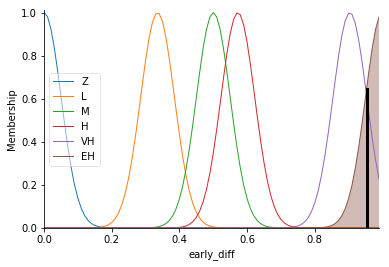

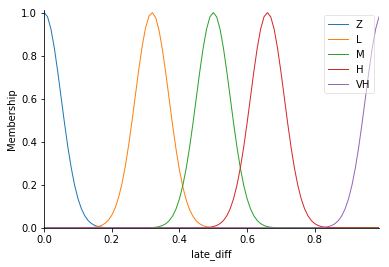

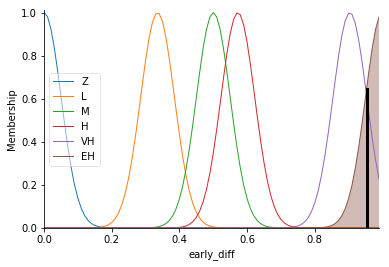

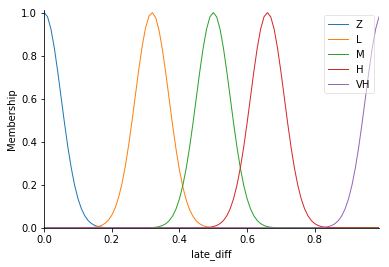

In [2]:
from observations import observations
from MSC_osteogenesis import all_params

with open('results/inferred_params.json') as file:
    inferred_params = json.load(file)
    
for key,value in inferred_params.items():
    all_params[key] = value
obj = Fuzzy_IL8_IL1b(all_params)
obj.forward(inputs={'IL8':100})
obj.forward(inputs={'IL8':100})

In [3]:
def scale(x,factor_u, factor_d):
    """
    Scale the fuzzy controller's output cosidering that the origin is x=0.5
    The scalling is done differently for x > 0.5 than x < 0.5
    x: fuzzy output
    factor: scale factor
    """
    if x >= 0.5:
        f = 2*factor_u*(x-0.5)+1
    else:
        f = 2*factor_d*(x-0.5)+1

    return f
print(scale(x=0.4533973281026269,factor_u=1,factor_d=0.46927666450109784))
print(scale(x=0.35477268300970155,factor_u=1,factor_d=0.46927666450109784))


0.9562609071503234
0.8636964181766983


In [4]:
"""
Plots membership functions for fuzzification. The `post` function takes care of plot appearence and saving.
Legends are exported seperately 
"""
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pathlib as pl
import os
import math
import copy
import pylab
import pylab
import matplotlib.font_manager
import matplotlib
import matplotlib.ticker as ticker
from matplotlib import rcParams
from skfuzzy import control as ctrl
rcParams["mathtext.default"]='rm'
rcParams['mathtext.fontset'] = 'stixsans'
# del matplotlib.font_manager.weight_dict['roman']
file_dir = "/Users/matin/Downloads/testProjs/MSC_M"
output_dir = os.path.join(file_dir,"graphs")
line_width  = 2
axis_font = {'fontname':'Times New Roman', 'size':'18'}
title_font = {'fontname':'Times New Roman', 'size':'20'}
legend_font = { 'family':'Times New Roman','size':'18'}
# colors = ['indigo','darkred','teal','royalblue','seagreen','tan']
colors = ['black','indigo' ,'grey','royalblue','olive','darkred']
line_patterns = [[8,2,8,2],[2,1,2,1],[8,1,8,1],[2,2,2,2],[4,1,4,1]]

format = ".svg"


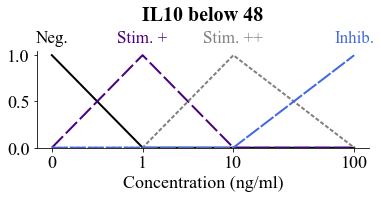

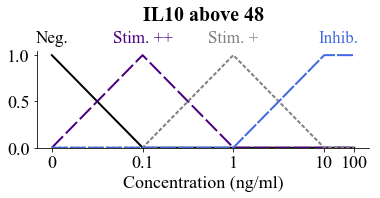

In [24]:
def post(ax,name,tags_x_locs,tags):
    """
    This function takes the fig and also the name of the plot and does post processing as well as saving the fig.
    """
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname(axis_font['fontname'])
        label.set_fontsize(float(axis_font['size']))
    ax.set_title(name,**title_font,fontweight='bold')
    if name == 'Early differentiation':
        ax.title.set_position([.5, 1.5])
    else:
        ax.title.set_position([.5, 1.25])
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    # ax.get_legend().remove()
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,prop=legend_font)
    # plt.tight_layout()
    # 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.subplots_adjust(left=0.11, right=0.95,bottom=0.25, top=0.7)
    ax.set_ylim([0,1.05])

    for i in range(len(tags)): 
        tags_x_loc = tags_x_locs[i]
        tag = tags[i]
        pos = 1.1
        if tag == 'Inhib.' and name == 'Mg$^{2+}$ ions':
            tags_x_loc = tags_x_loc-1.5
            pos = 0.45
            ax.text(tags_x_loc,pos,tag,size = 17, color = colors[i], rotation=45, fontname = 'Times New Roman',
               horizontalalignment='center',
            verticalalignment='bottom')
        else:
            ax.text(tags_x_loc,pos,tag,size = 17, color = colors[i], rotation='horizontal', fontname = 'Times New Roman',
               horizontalalignment='center',
            verticalalignment='bottom')

#     plt.savefig( os.path.join(output_dir,name+format))
def plot_IL10_below48():
    fig,ax = plt.subplots(figsize=(5.5, 3))
    intervals_real = [0,1,10,100]
    intervals = [0,6,12,20] #fake ones
    factor = ctrl.Antecedent(np.arange(0, intervals[-1], .005), 'IL10')
    # Generate fuzzy membership functions
    Neg = fuzz.trimf(factor.universe, [intervals[0], intervals[0],intervals[1]])
    LowStim = fuzz.trimf(factor.universe, [intervals[0], intervals[1], intervals[2]])
    HighStim = fuzz.trimf(factor.universe, [intervals[1], intervals[2], intervals[3]])
    Inhib = fuzz.trimf(factor.universe, [intervals[2], intervals[3], intervals[3]])

    factors = [Neg,LowStim,HighStim,Inhib]
    for i in range(len(factors)):
        if i == 0:
            linestyle = 'solid'
        else:
            linestyle = 'dashed'
        
        line, =ax.plot(factor.universe, factors[i],colors[i], linewidth=line_width,linestyle=linestyle)

        if i == 0:
            pass
        else:
            line.set_dashes(line_patterns[i-1])

    ax.set_xticks(intervals) 
    ax.set_xticklabels(intervals_real)
    # ax.set_ylabel('Membership',**axis_font)
    ax.set_xlabel('Concentration (ng/ml)',**axis_font)
    tags_x_locs = [intervals[0],intervals[1],intervals[2],intervals[3]]
    tags = ['Neg.','Stim. +','Stim. ++','Inhib.']
    return fig,ax,'IL10 below 48',tags_x_locs,tags
def plot_IL10_above48():
    fig,ax = plt.subplots(figsize=(5.5, 3))
    intervals_real = [0,0.1,1,10,100]
    intervals = [0,6,12,18,20] #fake ones
    factor = ctrl.Antecedent(np.arange(0, intervals[-1], .005), 'IL10')
    # Generate fuzzy membership functions
    Neg = fuzz.trimf(factor.universe, [intervals[0], intervals[0],intervals[1]])
    HighStim = fuzz.trimf(factor.universe, [intervals[0], intervals[1], intervals[2]])
    LowStim = fuzz.trimf(factor.universe, [intervals[1], intervals[2], intervals[3]])
    Inhib = fuzz.trapmf(factor.universe, [intervals[2], intervals[3], intervals[-1], intervals[-1]])

    factors = [Neg,HighStim,LowStim,Inhib]
    for i in range(len(factors)):
        if i == 0:
            linestyle = 'solid'
        else:
            linestyle = 'dashed'
        
        line, =ax.plot(factor.universe, factors[i],colors[i], linewidth=line_width,linestyle=linestyle)

        if i == 0:
            pass
        else:
            line.set_dashes(line_patterns[i-1])

    ax.set_xticks(intervals) 
    ax.set_xticklabels(intervals_real)
    # ax.set_ylabel('Membership',**axis_font)
    ax.set_xlabel('Concentration (ng/ml)',**axis_font)
    tags_x_locs = [intervals[0],intervals[1],intervals[2],intervals[3]+1]
    tags = ['Neg.','Stim. ++','Stim. +','Inhib.']
    return fig,ax,'IL10 above 48',tags_x_locs,tags

fig,ax,name,tags_x_locs,tags = plot_IL10_below48()
post( ax,name,tags_x_locs,tags)
fig,ax,name,tags_x_locs,tags = plot_IL10_above48()
post( ax,name,tags_x_locs,tags)

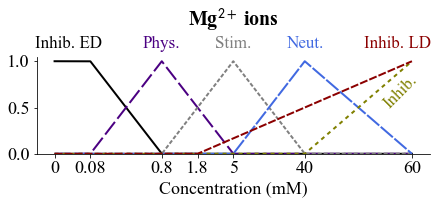

In [6]:
def plot_MG():
    fig = pylab.figure(figsize=(6.5, 3))
    ax = fig.add_subplot(111)
    max_value = 50
    factor = ctrl.Antecedent(np.arange(0, max_value, .005), 'Mg')
    intervals_real = [0,0.08,0.8,1.8,5,40,60]
    intervals = [0,5,15,20,25,35,50] #fake ones
    # Generate fuzzy membership functions
    Des_e = fuzz.trapmf(factor.universe, [intervals[0], intervals[0],intervals[1],intervals[2]])
    Phy = fuzz.trimf(factor.universe, [intervals[1],intervals[2],intervals[4]])
    Stim = fuzz.trimf(factor.universe, [intervals[2],intervals[4],intervals[5]])
    Neut = fuzz.trimf(factor.universe, [intervals[4],intervals[5],intervals[6]])
    Tox = fuzz.trapmf(factor.universe, [intervals[5],intervals[6],intervals[-1],intervals[-1]])
    Des_l = fuzz.trapmf(factor.universe, [intervals[3],intervals[6],intervals[-1],intervals[-1]])

    factors = [Des_e,Phy,Stim,Neut,Tox,Des_l]
    # Visualize these universes and membership functions
    for i in range(len(factors)):
        if i == 0:
            linestyle = 'solid'
        else:
            linestyle = 'dashed'
        
        line, =ax.plot(factor.universe, factors[i],colors[i], linewidth=line_width,linestyle=linestyle)

        if i == 0:
            pass
        else:
            line.set_dashes(line_patterns[i-1])
    
    #ax.set_title('BMP membership')
    ax.set_xticks(intervals) 
    ax.set_xticklabels(intervals_real)
    # ax.set_ylabel('Membership',**axis_font)
    ax.set_xlabel('Concentration (mM)',**axis_font)
    tags_x_locs = [intervals[0]+2,intervals[2],intervals[4],intervals[5],intervals[6],48]
    tags = ['Inhib. ED','Phys.','Stim.','Neut.','Inhib.','Inhib. LD']
    return fig,ax,'Mg$^{2+}$ ions',tags_x_locs,tags
fig,ax,name,tags_x_locs,tags = plot_MG()
post( ax,name,tags_x_locs,tags)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/matin/Downloads/testProjs/MSC_M/graphs/Mg$^{2+}$ ions.svg'

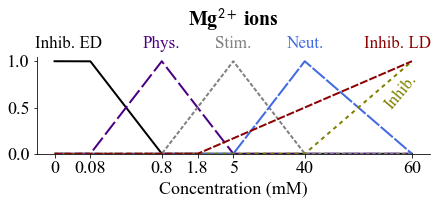

In [27]:
"""
Plots membership functions for fuzzification. The `post` function takes care of plot appearence and saving.
Legends are exported seperately 
"""
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pathlib as pl
import os
import math
import copy
import pylab
import pylab
import matplotlib.font_manager
import matplotlib
import matplotlib.ticker as ticker
from matplotlib import rcParams
from skfuzzy import control as ctrl
rcParams["mathtext.default"]='rm'
rcParams['mathtext.fontset'] = 'stixsans'
# del matplotlib.font_manager.weight_dict['roman']
cwd = os.getcwd()
output_dir = os.path.join(cwd,"graphs")
line_width  = 2
axis_font = {'fontname':'Times New Roman', 'size':'18'}
title_font = {'fontname':'Times New Roman', 'size':'20'}
legend_font = { 'family':'Times New Roman','size':'18'}
# colors = ['indigo','darkred','teal','royalblue','seagreen','tan']
colors = ['black','indigo' ,'grey','royalblue','olive','darkred']
line_patterns = [[8,2,8,2],[2,1,2,1],[8,1,8,1],[2,2,2,2],[4,1,4,1]]

format = ".svg"

def plot_IL8():
    fig,ax = plt.subplots(figsize=(5.5, 3))
    max_value = 10
    factor = ctrl.Antecedent(np.arange(0, max_value, .005), 'TNFa')
    intervals_real = [0,10,100]
    intervals = [0,3,10] #fake ones
    # Generate fuzzy membership functions
    neg = fuzz.trimf(factor.universe, [intervals[0], intervals[0],intervals[1]])
    lowStim = fuzz.trimf(factor.universe, [intervals[0], intervals[1], intervals[2]])
    highStim = fuzz.trimf(factor.universe, [intervals[1], intervals[2], intervals[2]])

    factors = [neg,lowStim,highStim]
    for i in range(len(factors)):
        if i == 0:
            linestyle = 'solid'
        else:
            linestyle = 'dashed'
        
        line, =ax.plot(factor.universe, factors[i],colors[i], linewidth=line_width,linestyle=linestyle)

        if i == 0:
            pass
        else:
            line.set_dashes(line_patterns[i-1])

    ax.set_xticks(intervals) 
    intervals_real[1] = r'$c_{1}$'
    ax.set_xticklabels(intervals_real)
    ax.set_xlabel('Concentration (mM)',**axis_font)
    tags_x_locs = [intervals[0],intervals[1],intervals[2]]
    tags = ['Neg.','Low Stim.','High Stim.']
    return fig,ax,'IL8',tags_x_locs,tags


def plot_IL1b():
    fig,ax = plt.subplots(figsize=(5.5, 3))
    max_value = 15
    factor = ctrl.Antecedent(np.arange(0, max_value, .005), 'TNFa')
    intervals_real = [0,10,50,200]
    intervals = [0,5,10,15] #fake ones
    # Generate fuzzy membership functions
    neg = fuzz.trimf(factor.universe, [intervals[0], intervals[0],intervals[1]])
    stim = fuzz.trimf(factor.universe, [intervals[0], intervals[1], intervals[2]])
    high = fuzz.trapmf(factor.universe, [intervals[1], intervals[2], intervals[3],intervals[3]])

    factors = [neg,stim,high]
    for i in range(len(factors)):
        if i == 0:
            linestyle = 'solid'
        else:
            linestyle = 'dashed'
        
        line, =ax.plot(factor.universe, factors[i],colors[i], linewidth=line_width,linestyle=linestyle)

        if i == 0:
            pass
        else:
            line.set_dashes(line_patterns[i-1])

    ax.set_xticks(intervals) 
    intervals_real[1] = r'$c_{2}$'
    intervals_real[2] = r'$c_{3}$'
    ax.set_xticklabels(intervals_real)
    ax.set_xlabel('Concentration (mM)',**axis_font)
    tags_x_locs = [intervals[0],intervals[1],intervals[2]+2]
    tags = ['Neg.','Stim.','High']
    return fig,ax,'IL1b',tags_x_locs,tags



def plot_MG():
    fig = pylab.figure(figsize=(6.5, 3))
    ax = fig.add_subplot(111)
    max_value = 50
    factor = ctrl.Antecedent(np.arange(0, max_value, .005), 'Mg')
    intervals_real = [0,0.08,0.8,1.8,5,40,60]
    intervals = [0,5,15,20,25,35,50] #fake ones
    # Generate fuzzy membership functions
    Des_e = fuzz.trapmf(factor.universe, [intervals[0], intervals[0],intervals[1],intervals[2]])
    Phy = fuzz.trimf(factor.universe, [intervals[1],intervals[2],intervals[4]])
    Stim = fuzz.trimf(factor.universe, [intervals[2],intervals[4],intervals[5]])
    Neut = fuzz.trimf(factor.universe, [intervals[4],intervals[5],intervals[6]])
    Tox = fuzz.trapmf(factor.universe, [intervals[5],intervals[6],intervals[-1],intervals[-1]])
    Des_l = fuzz.trapmf(factor.universe, [intervals[3],intervals[6],intervals[-1],intervals[-1]])

    factors = [Des_e,Phy,Stim,Neut,Tox,Des_l]
    # Visualize these universes and membership functions
    for i in range(len(factors)):
        if i == 0:
            linestyle = 'solid'
        else:
            linestyle = 'dashed'
        
        line, =ax.plot(factor.universe, factors[i],colors[i], linewidth=line_width,linestyle=linestyle)

        if i == 0:
            pass
        else:
            line.set_dashes(line_patterns[i-1])
    
    #ax.set_title('BMP membership')
    ax.set_xticks(intervals) 
    ax.set_xticklabels(intervals_real)
    # ax.set_ylabel('Membership',**axis_font)
    ax.set_xlabel('Concentration (mM)',**axis_font)
    tags_x_locs = [intervals[0]+2,intervals[2],intervals[4],intervals[5],intervals[6],48]
    tags = ['Inhib. ED','Phys.','Stim.','Neut.','Inhib.','Inhib. LD']
    return fig,ax,'Mg$^{2+}$ ions',tags_x_locs,tags

def plot_IL10_above48():
    fig,ax = plt.subplots(figsize=(5.5, 3))
    intervals_real = [0,0.1,1,10,100]
    intervals = [0,6,12,18,20] #fake ones
    factor = ctrl.Antecedent(np.arange(0, intervals[-1], .005), 'IL10')
    # Generate fuzzy membership functions
    Neg = fuzz.trimf(factor.universe, [intervals[0], intervals[0],intervals[1]])
    HighStim = fuzz.trimf(factor.universe, [intervals[0], intervals[1], intervals[2]])
    LowStim = fuzz.trimf(factor.universe, [intervals[1], intervals[2], intervals[3]])
    High = fuzz.trapmf(factor.universe, [intervals[2], intervals[3], intervals[-1], intervals[-1]])

    factors = [Neg,HighStim,LowStim,High]
    for i in range(len(factors)):
        if i == 0:
            linestyle = 'solid'
        else:
            linestyle = 'dashed'
        
        line, =ax.plot(factor.universe, factors[i],colors[i], linewidth=line_width,linestyle=linestyle)

        if i == 0:
            pass
        else:
            line.set_dashes(line_patterns[i-1])

    ax.set_xticks(intervals) 
    ax.set_xticklabels(intervals_real)
    # ax.set_ylabel('Membership',**axis_font)
    ax.set_xlabel('Concentration (ng/ml)',**axis_font)
    tags_x_locs = [intervals[0],intervals[1],intervals[2],intervals[3]+1]
    tags = ['Neg.','High Stim.','Low Stim.','High']
    return fig,ax,'IL10 above 48',tags_x_locs,tags

def plot_IL10_below48():
    fig,ax = plt.subplots(figsize=(5.5, 3))
    intervals_real = [0,1,10,100]
    intervals = [0,6,12,20] #fake ones
    factor = ctrl.Antecedent(np.arange(0, intervals[-1], .005), 'IL10')
    # Generate fuzzy membership functions
    Neg = fuzz.trimf(factor.universe, [intervals[0], intervals[0],intervals[1]])
    LowStim = fuzz.trimf(factor.universe, [intervals[0], intervals[1], intervals[2]])
    HighStim = fuzz.trimf(factor.universe, [intervals[1], intervals[2], intervals[3]])
    High = fuzz.trimf(factor.universe, [intervals[2], intervals[3], intervals[3]])

    factors = [Neg,LowStim,HighStim,High]
    for i in range(len(factors)):
        if i == 0:
            linestyle = 'solid'
        else:
            linestyle = 'dashed'
        
        line, =ax.plot(factor.universe, factors[i],colors[i], linewidth=line_width,linestyle=linestyle)

        if i == 0:
            pass
        else:
            line.set_dashes(line_patterns[i-1])

    ax.set_xticks(intervals) 
    ax.set_xticklabels(intervals_real)
    # ax.set_ylabel('Membership',**axis_font)
    ax.set_xlabel('Concentration (ng/ml)',**axis_font)
    tags_x_locs = [intervals[0],intervals[1],intervals[2],intervals[3]]
    tags = ['Neg.','Low Stim.','High Stim.','High']
    return fig,ax,'IL10 below 48',tags_x_locs,tags
def plot_TNFa():
    fig,ax = plt.subplots(figsize=(5.5, 3))
    max_value = 10
    factor = ctrl.Antecedent(np.arange(0, max_value, .005), 'TNFa')
    intervals_real = [0,1,10]
    intervals = [0,3,10] #fake ones
    # Generate fuzzy membership functions
    neg = fuzz.trimf(factor.universe, [intervals[0], intervals[0],intervals[1]])
    stim = fuzz.trimf(factor.universe, [intervals[0], intervals[1], intervals[2]])
    high = fuzz.trimf(factor.universe, [intervals[1], intervals[2], intervals[2]])

    factors = [neg,stim,high]
    for i in range(len(factors)):
        if i == 0:
            linestyle = 'solid'
        else:
            linestyle = 'dashed'
        
        line, =ax.plot(factor.universe, factors[i],colors[i], linewidth=line_width,linestyle=linestyle)

        if i == 0:
            pass
        else:
            line.set_dashes(line_patterns[i-1])

    ax.set_xticks(intervals) 
    ax.set_xticklabels(intervals_real)
    ax.set_xlabel('Concentration (mM)',**axis_font)
    tags_x_locs = [intervals[0],intervals[1],intervals[2]]
    tags = ['Neg.','Stim.','High']
    return fig,ax,'TNFa',tags_x_locs,tags

def plot_earlyDiff():
    fig,ax = plt.subplots(figsize=(5.5, 3))
    max_value = 1.1
    factor = ctrl.Antecedent(np.arange(0, max_value, .005), 'earlyDiff')
    sigma = .05
    intervals_real = [0,.25,.5,.667,0.833, 1]
    intervals = [0,.2,.4,.6,0.82, 1.1] #fake ones
    # Generate fuzzy membership functions
    Z=fuzz.gaussmf(factor.universe, intervals[0], sigma)
    L=fuzz.gaussmf(factor.universe, intervals[1], sigma)
    M=fuzz.gaussmf(factor.universe, intervals[2], sigma)
    H=fuzz.gaussmf(factor.universe, intervals[3], sigma)
    VH=fuzz.gaussmf(factor.universe, intervals[4], sigma)
    EH=fuzz.gaussmf(factor.universe, intervals[5], sigma)
    
    factors = [Z,L,M,H,VH,EH]
    for i in range(len(factors)):
        if i == 0:
            linestyle = 'solid'
        else:
            linestyle = 'dashed'
        
        line, =ax.plot(factor.universe, factors[i],colors[i], linewidth=line_width,linestyle=linestyle)

        if i == 0:
            pass
        else:
            line.set_dashes(line_patterns[i-1])
#     plt.rcParams['axes.titley'] = 1.0 
    ax.set_xticks(intervals) 
    intervals_real[1] = r'$c_{1}$'
    intervals_real[3] = r'$c_{2}$'
    intervals_real[4] = r'$c_{3}$'
    ax.set_xticklabels(intervals_real)
    ax.set_xlabel('Intensity',**axis_font)
    tags_x_locs = [intervals[0],intervals[1],intervals[2],intervals[3],intervals[4],intervals[5]]
    tags = ['Zero','Low','Phys.','High','Very high','Ext. high']
    return fig,ax,'Early differentiation',tags_x_locs,tags

def plot_lateDiff():
    fig,ax = plt.subplots(figsize=(5.5, 3))
    max_value = 1
    factor = ctrl.Antecedent(np.arange(0, max_value, .005), 'lateDiff')
    sigma = .05
    intervals_real = [0,.25,.5,.75, 1]
    intervals = [0,.25,.5,.75, 1] #fake ones
    # Generate fuzzy membership functions
    Z=fuzz.gaussmf(factor.universe, intervals[0], sigma)
    L=fuzz.gaussmf(factor.universe, intervals[1], sigma)
    M=fuzz.gaussmf(factor.universe, intervals[2], sigma)
    H=fuzz.gaussmf(factor.universe, intervals[3], sigma)
    VH=fuzz.gaussmf(factor.universe, intervals[4], sigma)
    
    factors = [Z,L,M,H,VH]
    for i in range(len(factors)):
        if i == 0:
            linestyle = 'solid'
        else:
            linestyle = 'dashed'
        
        line, =ax.plot(factor.universe, factors[i],colors[i], linewidth=line_width,linestyle=linestyle)

        if i == 0:
            pass
        else:
            line.set_dashes(line_patterns[i-1])
#     plt.rcParams['axes.titley'] = 1.0 
    ax.set_xticks(intervals) 
    intervals_real[1] = r'$c_{1}$'
    intervals_real[3] = r'$c_{2}$'
    ax.set_xticklabels(intervals_real)
    ax.set_xlabel('Intensity',**axis_font)
    tags_x_locs = [intervals[0],intervals[1],intervals[2],intervals[3],intervals[4]]
    tags = ['Zero','Low','Phys.','High','Very high']
    return fig,ax,'Late differentiation',tags_x_locs,tags

def post(ax,name,tags_x_locs,tags):
    """
    This function takes the fig and also the name of the plot and does post processing as well as saving the fig.
    """
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname(axis_font['fontname'])
        label.set_fontsize(float(axis_font['size']))
    ax.set_title(name,**title_font,fontweight='bold')
    ax.title.set_position([.5, 1.25])
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    # ax.get_legend().remove()
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,prop=legend_font)
    # plt.tight_layout()
    # 
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.subplots_adjust(left=0.11, right=0.95,bottom=0.25, top=0.7)
    ax.set_ylim([0,1.05])

    for i in range(len(tags)): 
        tags_x_loc = tags_x_locs[i]
        tag = tags[i]
        pos = 1.1
        if tag == 'Inhib.' and name == 'Mg$^{2+}$ ions':
            tags_x_loc = tags_x_loc-1.5
            pos = 0.45
            ax.text(tags_x_loc,pos,tag,size = 17, color = colors[i], rotation=50, fontname = 'Times New Roman',
               horizontalalignment='center',
            verticalalignment='bottom')
        else:
            ax.text(tags_x_loc,pos,tag,size = 17, color = colors[i], rotation='horizontal', fontname = 'Times New Roman',
               horizontalalignment='center',
            verticalalignment='bottom')

    plt.savefig( os.path.join(output_dir,name+format))
def plot_legends():
    fig = pylab.figure(figsize=(5.5, 3))
    ax = fig.add_subplot(111)
    fakes = {0.8:5,5:12,15:20,40:29,60:40} # fake positions maping
    range = np.arange(0, 40, .5)
    # Generate fuzzy membership functions
    neg = fuzz.trapmf(range, [0,0,0.8,5])
    low = fuzz.trimf(range, [0.8,5,15])
    medium = fuzz.trimf(range, [5,15,40])
    high = fuzz.trapmf(range, [15,40,60,60])
    # fake the values
    fake_neg = fuzz.trapmf(range, [0,0,fakes[0.8],fakes[5]])
    fake_low = fuzz.trimf(range, [fakes[0.8],fakes[5],fakes[15]])
    fake_medium = fuzz.trimf(range, [fakes[5],fakes[15],fakes[40]])
    fake_high = fuzz.trapmf(range, [fakes[15],fakes[40],fakes[60],fakes[60]])
    # Visualize these universes and membership functions
    line1, =ax.plot(range, fake_neg,colors['neg'], linewidth=line_width, label='Negligible',linestyle=linestyles['neg'])
    line2, =ax.plot(range, fake_low, colors['low'], linewidth=line_width, label='Low',linestyle=linestyles['low'])
    line2.set_dashes([1, 1, 1, 1])
    line3, =ax.plot(range, fake_medium, colors['medium'], linewidth=line_width, label='medium',linestyle=linestyles['medium'])
    line3.set_dashes([2, 1, 2, 1])
    line4, =ax.plot(range, fake_high, colors['high'], linewidth=line_width, label='High',linestyle=linestyles['high'])
    line4.set_dashes([4, 2, 4, 2])
    #ax.set_title('BMP membership')
    ax.set_xticks([0,fakes[0.8],fakes[5],fakes[15],fakes[40],fakes[60]]) 
    ax.set_xticklabels([0,0.8,r'$c_{mlt}$',r'$c_{mmt}$',r'$c_{mht}$',60])
    # ax.set_ylabel('Membership',**axis_font)
    ax.set_xlabel('Concentration (mM)',**axis_font)
    return fig,ax,'legends'

fig,ax,name,tags_x_locs,tags = plot_MG()
post( ax,name,tags_x_locs,tags)

fig,ax,name,tags_x_locs,tags = plot_IL10_above48()
post( ax,name,tags_x_locs,tags)

fig,ax,name,tags_x_locs,tags = plot_IL10_below48()
post( ax,name,tags_x_locs,tags)

fig,ax,name,tags_x_locs,tags = plot_TNFa()
post( ax,name,tags_x_locs,tags)

fig,ax,name,tags_x_locs,tags = plot_IL8()
post( ax,name,tags_x_locs,tags)

fig,ax,name,tags_x_locs,tags = plot_IL1b()
post( ax,name,tags_x_locs,tags)

fig,ax,name,tags_x_locs,tags = plot_earlyDiff()
post( ax,name,tags_x_locs,tags)

fig,ax,name,tags_x_locs,tags = plot_lateDiff()
post( ax,name,tags_x_locs,tags)
# 
# fig,ax,name,tags_x_locs,tags= plot_MG()
# post( ax,name,tags_x_locs,tags)
# fig,ax,name = plot_legends()
# post( ax,name)

def export_legend(axes):
    figLegend = pylab.figure(figsize = (1.5,1.3))
    pylab.figlegend(*axes.get_legend_handles_labels(), loc = 'upper left')
    figLegend.savefig(os.path.join(output_dir,'legend.svg'))
export_legend(ax)